In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
def draw_sample_image(X,Y):
    labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    X, Y = shuffle(X, Y)
    for i in xrange(20):
        plt.subplot(4,5,i)
        img = X[i].reshape(32,32,3)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(labels[Y[i]])
    plt.show()

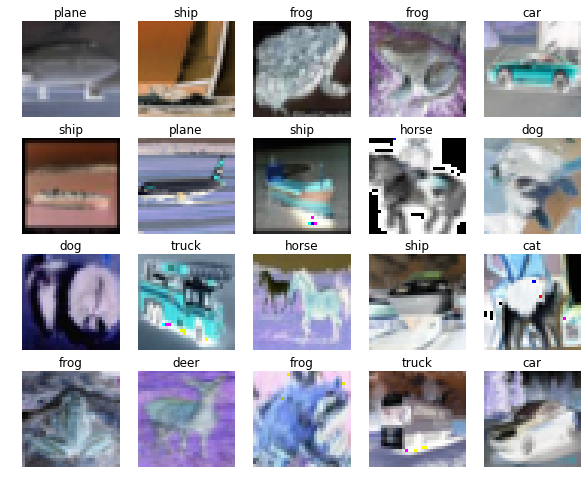

In [4]:
draw_sample_image(X_train,y_train)

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) /255
# X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
# X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
# print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
# print 'dev data shape: ', X_dev.shape

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


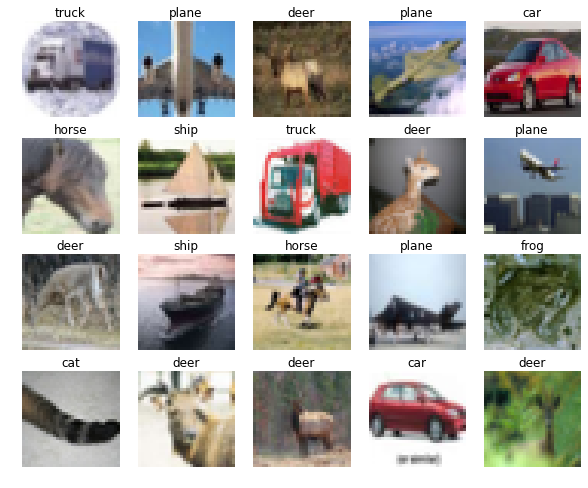

In [6]:
draw_sample_image(X_train,y_train)

In [7]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)
def cost(T,Y):
    return -(T*np.log(Y)).sum()
def y2indicator(Y):
    N = Y.shape[0]
    K = len(set(Y))
    Y_ind = np.zeros((N,K))
    for i in xrange(N):
        Y_ind[i,Y[i]] = 1
    return Y_ind
def error_rate(targets,predictions):
    return np.mean(targets != predictions)
def relu(x):
    return x*(x>0)
def derivative_w2(Z,T,Y):
    return Z.T.dot(T-Y)
def derivative_b2(T,Y):
    return (T-Y).sum(axis=0)
def derivative_w1(X, Z, T, Y, W2):
#     return X.T.dot((T-Y).dot(W2.T)*Z*(1-Z))
    return X.T.dot((T-Y).dot(W2.T)*(Z>0))
def derivative_b1(Z, T, Y, W2):
#     return ((T-Y).dot(W2.T)*Z*(1-Z)).sum(axis=0)
    return ((T-Y).dot(W2.T)*(Z>0)).sum(axis=0)


In [16]:
class NN(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-6,reg=1e-6,epochs=500000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 5
        self.W1 = np.random.randn(D,M) / np.sqrt(D+M)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M+K)
        self.b2 = np.zeros(K)
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            P_Y_train, hidden = self.forward(X_train)
            self.W2 += learning_rate*(derivative_w2(hidden,T_train_ind,P_Y_train) + reg*self.W2)
            self.b2 += learning_rate*(derivative_b2(T_train_ind,P_Y_train) + reg*self.b2)
            self.W1 += learning_rate*(derivative_w1(X_train,hidden,T_train_ind,P_Y_train,self.W2)
                                      + reg*self.W1)
            self.b1 += learning_rate*(derivative_b1(hidden,T_train_ind,P_Y_train,self.W2) + 
                                      reg*self.b1)
            if epoch % 1000 == 0:
                P_Y_valid, _ = self.forward(X_valid)
                c = cost(T_valid_ind,P_Y_valid)
                costs.append(c)
                e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                print "epoch: ",epoch, "cost: ",c, "error: ", e
            if e < best_validation_error:
                best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

epoch:  0 cost:  2295.7671528 error:  0.905
epoch:  500 cost:  2156.46753958 error:  0.787
epoch:  1000 cost:  2082.83415599 error:  0.766
epoch:  1500 cost:  2025.75100067 error:  0.76
epoch:  2000 cost:  1983.35548898 error:  0.716
epoch:  2500 cost:  1954.0867907 error:  0.706
epoch:  3000 cost:  1931.56396808 error:  0.699
epoch:  3500 cost:  1913.11823369 error:  0.688
epoch:  4000 cost:  1897.40906103 error:  0.681
epoch:  4500 cost:  1883.69594807 error:  0.674
epoch:  5000 cost:  1872.27772186 error:  0.658
epoch:  5500 cost:  1862.98065481 error:  0.654
epoch:  6000 cost:  1854.62392067 error:  0.656
epoch:  6500 cost:  1847.32184865 error:  0.649
epoch:  7000 cost:  1840.77727973 error:  0.641
epoch:  7500 cost:  1834.70524208 error:  0.634
epoch:  8000 cost:  1829.10188243 error:  0.636
epoch:  8500 cost:  1823.69574998 error:  0.636
epoch:  9000 cost:  1818.70588072 error:  0.632
epoch:  9500 cost:  1814.07884882 error:  0.631
best validation error:  1


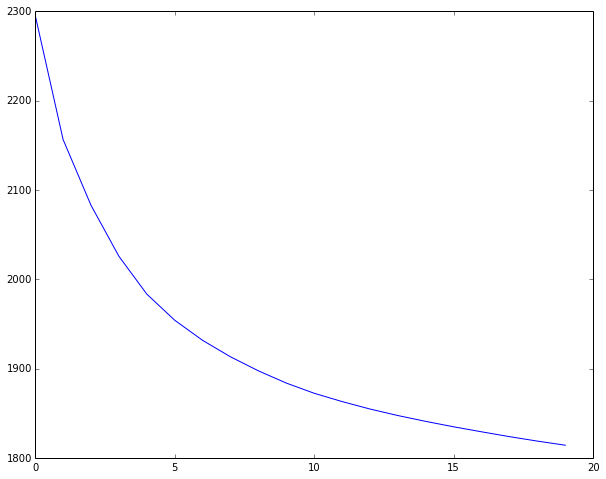

In [10]:
nn_classifier = NN()
nn_classifier.train(X_train,y_train)

In [14]:
def cross_validation(model,X,Y,lr,reg,k_fold=5):
    fold_size = len(Y)/k_fold
    X, Y = shuffle(X, Y)
    scores = []
    for k in xrange(k_fold):
        X_train = np.concatenate([X[:k*fold_size,:],X[:k*fold_size + fold_size,:]])
        Y_train = np.concatenate([Y[:k*fold_size],Y[:k*fold_size + fold_size]])
        X_test = X[k*fold_size:k*fold_size+fold_size]
        Y_test = Y[k*fold_size:k*fold_size+fold_size]
        model.train(X_train,Y_train,learning_rate=lr,reg=reg,show_fig=False)
        score = model.score(X_test,Y_test)
        scores.append(score)
    return np.mean(scores), model

In [15]:
learning_rates = [10e-8, 10e-7,10e-6,10e-5,10e-4]
regularization_strengths = [10e-12,10e-11,10e-10,10e-9,10e-8,10e-7]
results = {}
best_score = -1   # The highest validation accuracy that we have seen so far.
for lr in learning_rates:
    for rg in regularization_strengths:
        print "############testing on model with lr:",lr,"reg:",rg," ###########"
        model = NN()
        test_score, model = cross_validation(model,X_train,y_train,lr,rg)
        results[(lr,rg)] = test_score
        if test_score > best_score:
            best_score = test_score
for lr, rg in sorted(results):
    test_score = results[(lr, rg)]
    print 'lr %e reg %e test score: %f' % (lr, rg, test_score)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_score

############testing on model with lr: 1e-07 reg: 1e-11  ###########
epoch:  0 cost:  2303.09759225 error:  0.903
epoch:  50 cost:  2300.18186891 error:  0.893
epoch:  100 cost:  2296.84540008 error:  0.884
best validation error:  0.884
epoch:  0 cost:  2318.4323571 error:  0.897
epoch:  50 cost:  2299.57645915 error:  0.906
epoch:  100 cost:  2294.28450157 error:  0.899
best validation error:  0.897
epoch:  0 cost:  2319.80134406 error:  0.893
epoch:  50 cost:  2284.23757566 error:  0.846
epoch:  100 cost:  2268.01740387 error:  0.832
best validation error:  0.832
epoch:  0 cost:  2298.51550523 error:  0.881
epoch:  50 cost:  2245.13205712 error:  0.824
epoch:  100 cost:  2222.77401994 error:  0.808
best validation error:  0.808
epoch:  0 cost:  2303.58920505 error:  0.909
epoch:  50 cost:  2272.86077708 error:  0.905
epoch:  100 cost:  2255.20287433 error:  0.896
best validation error:  0.896
############testing on model with lr: 1e-07 reg: 1e-10  ###########
epoch:  0 cost:  2313.813

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in exp
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in divide
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


epoch:  50 cost:  nan error:  0.892
epoch:  100 cost:  nan error:  0.892
best validation error:  0.892
epoch:  0 cost:  2302.71666314 error:  0.901
epoch:  50 cost:  2302.92485012 error:  0.911
epoch:  100 cost:  2302.93430879 error:  0.911
best validation error:  0.901
epoch:  0 cost:  2310.41024944 error:  0.896
epoch:  50 cost:  2302.79595497 error:  0.911
epoch:  100 cost:  2302.79753596 error:  0.911
best validation error:  0.896
############testing on model with lr: 1e-05 reg: 1e-10  ###########
epoch:  0 cost:  2284.66468193 error:  0.896
epoch:  50 cost:  2192.40959398 error:  0.844
epoch:  100 cost:  2156.9866778 error:  0.825
best validation error:  0.825
epoch:  0 cost:  2302.57125247 error:  0.891
epoch:  50 cost:  2302.07425359 error:  0.896
epoch:  100 cost:  2302.03499147 error:  0.896
best validation error:  0.891
epoch:  0 cost:  2302.49151239 error:  0.887
epoch:  50 cost:  2302.82890748 error:  0.909
epoch:  100 cost:  2302.87544196 error:  0.909
best validation erro

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


epoch:  0 cost:  nan error:  0.887
epoch:  50 cost:  nan error:  0.887
epoch:  100 cost:  nan error:  0.887
best validation error:  0.887
epoch:  0 cost:  nan error:  0.893
epoch:  50 cost:  nan error:  0.89
epoch:  100 cost:  nan error:  0.89
best validation error:  0.89
epoch:  0 cost:  nan error:  0.899
epoch:  50 cost:  nan error:  0.899
epoch:  100 cost:  nan error:  0.899
best validation error:  0.899
epoch:  0 cost:  nan error:  0.898
epoch:  50 cost:  nan error:  0.898
epoch:  100 cost:  nan error:  0.898
best validation error:  0.898
epoch:  0 cost:  nan error:  0.896
epoch:  50 cost:  nan error:  0.901
epoch:  100 cost:  nan error:  0.901
best validation error:  0.896
############testing on model with lr: 0.001 reg: 1e-10  ###########
epoch:  0 cost:  15191.7761379 error:  0.907
epoch:  50 cost:  nan error:  0.904
epoch:  100 cost:  nan error:  0.904
best validation error:  0.904
epoch:  0 cost:  150676.614211 error:  0.89
epoch:  50 cost:  nan error:  0.898
epoch:  100 cost:

In [17]:
nn_classifier = NN()
nn_classifier.train(X_train,y_train)

epoch:  0 cost:  2302.54481339 error:  0.926
epoch:  1000 cost:  2023.09372084 error:  0.736
epoch:  2000 cost:  1929.79272238 error:  0.702
epoch:  3000 cost:  1911.0463609 error:  0.712
epoch:  4000 cost:  1887.09018588 error:  0.689
epoch:  5000 cost:  1895.45018369 error:  0.686
epoch:  6000 cost:  1870.09349466 error:  0.694
epoch:  7000 cost:  1863.13188527 error:  0.679
epoch:  8000 cost:  1834.26759911 error:  0.651
epoch:  9000 cost:  1823.12008852 error:  0.648
epoch:  10000 cost:  1828.46295959 error:  0.643
epoch:  11000 cost:  1824.4609841 error:  0.64
epoch:  12000 cost:  1810.12652413 error:  0.65
epoch:  13000 cost:  1812.27210563 error:  0.645


KeyboardInterrupt: 